### Import bibliotek

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### Definicja funkcji celu

In [108]:
def objectives(u):
    x, y = u
    f1 = x**2 + y**2
    f2 = (x - 1)**2 + (y + 1)**2
    return np.array([f1, f2])

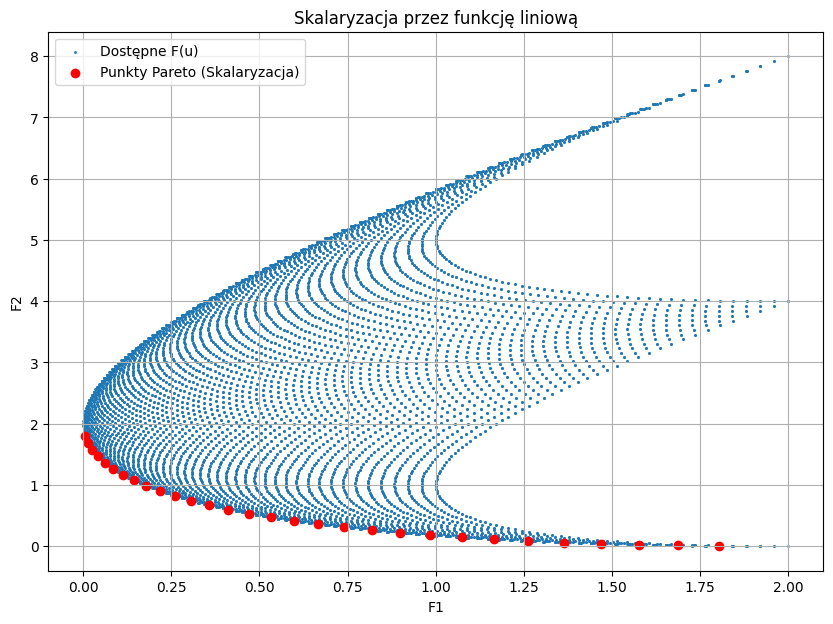

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def objectives(u):
    x, y = u
    f1 = x**2 + y**2
    f2 = (x - 1)**2 + (y + 1)**2
    return np.array([f1, f2])

def gradient_descent(objective, gradient, u0, bounds, learning_rate=0.05, max_iters=1000, tol=1e-6):
    u = np.array(u0, dtype=float)
    for i in range(max_iters):
        grad = gradient(u)
        u_new = u - learning_rate * grad

        # Projekcja u_new na ograniczenia
        for j in range(len(u)):
            u_new[j] = np.clip(u_new[j], bounds[j][0], bounds[j][1])

        # Sprawdzenie zbieżności
        if np.linalg.norm(u_new - u) < tol:
            break

        u = u_new

    return u

def F1(u):
    x, y = u
    return x**2 + y**2

def F2(u):
    x, y = u
    return (x - 1)**2 + (y + 1)**2

def grad_F1(u):
    x, y = u
    return np.array([2 * x, 2 * y])

def grad_F2(u):
    x, y = u
    return np.array([2 * (x - 1), 2 * (y + 1)])

def scalarization_linear_objective(u, lambd):
    lambda1, lambda2 = lambd
    return lambda1 * F1(u) + lambda2 * F2(u)

def scalarization_linear_gradient(u, lambd):
    lambda1, lambda2 = lambd
    return lambda1 * grad_F1(u) + lambda2 * grad_F2(u)

def scalarization_linear(u0, lambd):
    def objective(u):
        return scalarization_linear_objective(u, lambd)

    def gradient(u):
        return scalarization_linear_gradient(u, lambd)

    bounds = [(-1, 1), (-1, 1)]
    u_opt = gradient_descent(objective, gradient, u0, bounds)
    return u_opt

# Generowanie rozwiązań
lambda_values = np.linspace(0.05, 0.95, 30)
solutions = []

for lambda1 in lambda_values:
    lambd = np.array([lambda1, 1 - lambda1])
    u_opt = scalarization_linear(u0=[0, 0], lambd=lambd)
    solutions.append((u_opt, np.array([F1(u_opt), F2(u_opt)])))

F_values = np.array([sol[1] for sol in solutions])

# Generowanie przestrzeni funkcji celu
x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_vals, y_vals)
U_grid = np.column_stack([X.ravel(), Y.ravel()])
F_all = np.array([objectives(u) for u in U_grid])

# Wizualizacja
plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Skalaryzacja)')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Skalaryzacja przez funkcję liniową')
plt.legend()
plt.grid(True)
plt.show()


<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:42: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:42: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Jakub\AppData\Local\Temp\ipykernel_9244\1083765174.py:39: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Metoda $\epsilon$-ograniczeń)')
C:\Users\Jakub\AppData\Local\Temp\ipykernel_9244\1083765174.py:42: SyntaxWarning: invalid escape sequence '\e'
  plt.title('Metoda $\epsilon$-ograniczeń')


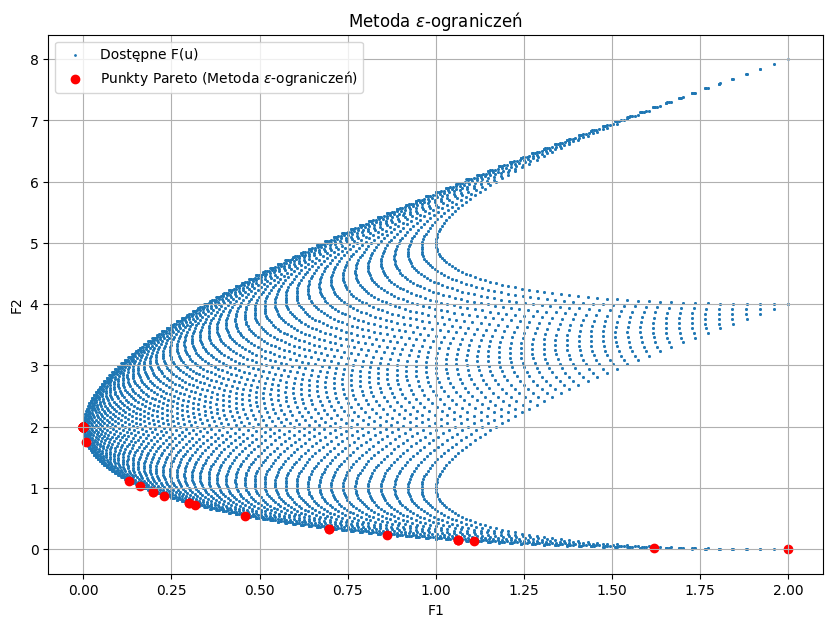

In [110]:
def epsilon_constraint_objective(u, epsilon, penalty_coefficient=1000):
    f1_value = F1(u)
    f2_value = F2(u)
    penalty = penalty_coefficient * max(0, f2_value - epsilon)**2
    return f1_value + penalty

def epsilon_constraint_gradient(u, epsilon, penalty_coefficient=1000):
    grad = grad_F1(u)
    f2_value = F2(u)
    if f2_value > epsilon:
        penalty_grad = penalty_coefficient * 2 * (f2_value - epsilon) * grad_F2(u)
        grad += penalty_grad
    return grad

def epsilon_constraint_optimization(u0, epsilon):
    def objective(u):
        return epsilon_constraint_objective(u, epsilon)

    def gradient(u):
        return epsilon_constraint_gradient(u, epsilon)

    bounds = [(-1, 1), (-1, 1)]
    u_opt = gradient_descent(objective, gradient, u0, bounds)
    return u_opt

# Generowanie rozwiązań
epsilon_values = np.linspace(np.min(F_all[:, 1]), np.max(F_all[:, 1]), 75)
solutions = []

for epsilon in epsilon_values:
    u_opt = epsilon_constraint_optimization(u0=[0, 0], epsilon=epsilon)
    solutions.append((u_opt, np.array([F1(u_opt), F2(u_opt)])))

F_values = np.array([sol[1] for sol in solutions])

# Wizualizacja
plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Metoda $\epsilon$-ograniczeń)')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Metoda $\epsilon$-ograniczeń')
plt.legend()
plt.grid(True)
plt.show()


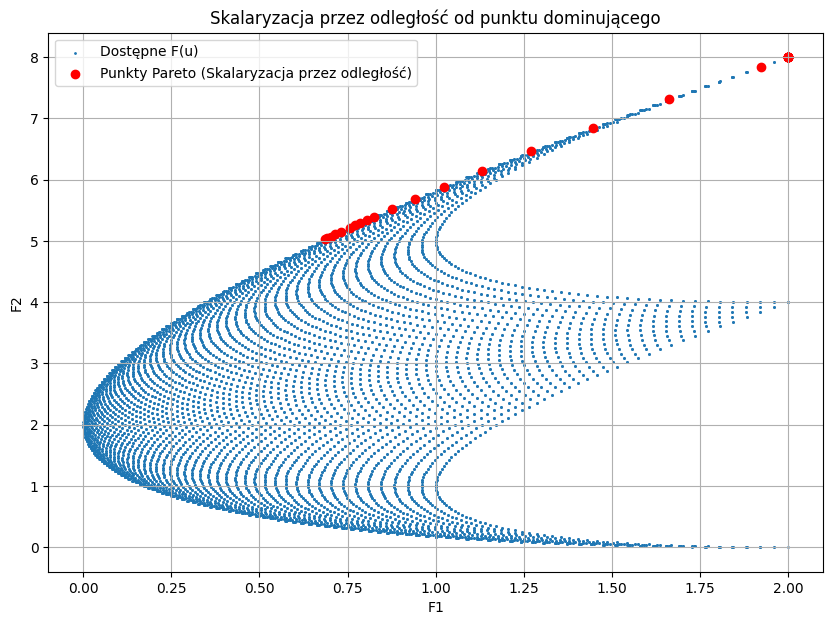

In [111]:
def scalarization_distance_objective(u, x_dominating, lambd):
    diff = np.array([F1(u) - x_dominating[0], F2(u) - x_dominating[1]])
    weighted_diff = lambd * diff
    return np.linalg.norm(weighted_diff)

def scalarization_distance_gradient(u, x_dominating, lambd):
    diff = np.array([F1(u) - x_dominating[0], F2(u) - x_dominating[1]])
    weighted_diff = lambd * diff
    D_u = np.linalg.norm(weighted_diff)
    if D_u == 0:
        return np.zeros_like(u)
    grad = (lambd[0]**2 * (F1(u) - x_dominating[0]) * grad_F1(u) +
            lambd[1]**2 * (F2(u) - x_dominating[1]) * grad_F2(u)) / D_u
    return grad

def scalarization_distance(u0, x_dominating, lambd):
    def objective(u):
        return scalarization_distance_objective(u, x_dominating, lambd)

    def gradient(u):
        return scalarization_distance_gradient(u, x_dominating, lambd)

    bounds = [(-1, 1), (-1, 1)]
    u_opt = gradient_descent(objective, gradient, u0, bounds)
    return u_opt

# Generowanie rozwiązań
dominating_point = np.array([5.0, 5.0])  # Punkt dominujący
lambda_values = np.linspace(0.05, 0.95, 30)
solutions = []

for lambda1 in lambda_values:
    lambd = np.array([lambda1, 1 - lambda1])
    u_opt = scalarization_distance(u0=[0, 0], x_dominating=dominating_point, lambd=lambd)
    solutions.append((u_opt, np.array([F1(u_opt), F2(u_opt)])))

F_values = np.array([sol[1] for sol in solutions])

# Wizualizacja
plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Skalaryzacja przez odległość)')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Skalaryzacja przez odległość od punktu dominującego')
plt.legend()
plt.grid(True)
plt.show()


### Rozszerzenie na Problem z Trzema Kryteriami

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def G1(u):
    x, y, z = u
    return x**2 + y**2 + z**2

def G2(u):
    x, y, z = u
    return (x - 1)**2 + (y + 1)**2 + z**2

def G3(u):
    x, y, z = u
    return x**3 + y**3 + z**3  # Nieliniowa funkcja

def grad_G1(u):
    x, y, z = u
    return np.array([2 * x, 2 * y, 2 * z])

def grad_G2(u):
    x, y, z = u
    return np.array([2 * (x - 1), 2 * (y + 1), 2 * z])

def grad_G3(u):
    x, y, z = u
    return np.array([3 * x**2, 3 * y**2, 3 * z**2])

def objectives(u):
    return np.array([G1(u), G2(u), G3(u)])


In [142]:
from itertools import product

# Generowanie siatki punktów w dziedzinie U
num_points = 20  # Możesz dostosować tę wartość w zależności od mocy obliczeniowej
u_vals = np.linspace(-1, 1, num_points)
U_grid = np.array(list(product(u_vals, repeat=3)))

# Obliczanie wartości funkcji celu dla każdego punktu w U
G_all = np.array([objectives(u) for u in U_grid])


###  Implementacja algorytmu gradientu prostego

In [143]:
def gradient_descent_n(objective, gradient, u0, bounds, learning_rate=0.01, max_iters=5000, tol=1e-8):
    u = np.array(u0, dtype=float)
    for i in range(max_iters):
        grad = gradient(u)
        u_new = u - learning_rate * grad

        # Projekcja u_new na ograniczenia
        for j in range(len(u)):
            u_new[j] = np.clip(u_new[j], bounds[j][0], bounds[j][1])

        # Sprawdzenie zbieżności
        if np.linalg.norm(u_new - u) < tol:
            break

        u = u_new

    return u


###  Implementacja Skalaryzacji przez Funkcję Liniową

In [144]:
def scalarization_linear_objective_n(u, lambd):
    G_values = objectives(u)
    return np.dot(lambd, G_values)

def scalarization_linear_gradient_n(u, lambd):
    grad_G_values = np.array([grad_G1(u), grad_G2(u), grad_G3(u)])
    return np.dot(lambd, grad_G_values)


In [145]:
def scalarization_linear_n(u0, lambd):
    def objective(u):
        return scalarization_linear_objective_n(u, lambd)

    def gradient(u):
        return scalarization_linear_gradient_n(u, lambd)

    bounds = [(-1, 1), (-1, 1), (-1, 1)]
    u_opt = gradient_descent_n(objective, gradient, u0, bounds)
    return u_opt


In [146]:
# Generowanie kombinacji lambda
lambda_values = np.linspace(0.1, 0.9, 5)
solutions = []

for lambda1 in lambda_values:
    for lambda2 in lambda_values:
        lambda3 = 1.0 - lambda1 - lambda2
        if lambda3 >= 0:
            lambd = np.array([lambda1, lambda2, lambda3])
            u_opt = scalarization_linear_n(u0=[0, 0, 0], lambd=lambd)
            G_opt = objectives(u_opt)
            solutions.append((u_opt, G_opt))


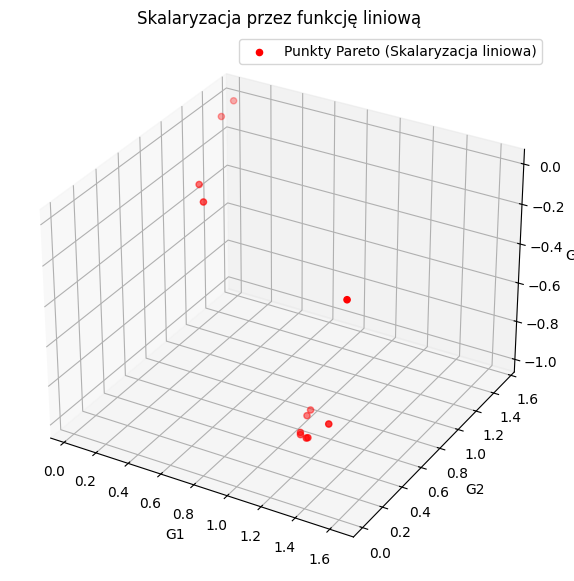

In [149]:
# Ekstrakcja wartości G
G_pareto = np.array([sol[1] for sol in solutions])

# Wizualizacja 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Wszystkie dostępne wartości G(u)
# ax.scatter(G_all[:, 0], G_all[:, 1], G_all[:, 2], s=5, color='gray', alpha=0.5, label='Dostępne G(u)')

# Punkty Pareto
ax.scatter(G_pareto[:, 0], G_pareto[:, 1], G_pareto[:, 2], color='red', label='Punkty Pareto (Skalaryzacja liniowa)')

ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')
ax.set_title('Skalaryzacja przez funkcję liniową')
ax.legend()
plt.show()



### Implementacja Metody ϵ-Ograniczeń

In [150]:
def epsilon_constraint_objective_n(u, epsilons, penalty_coefficient=1000):
    G_values = objectives(u)
    penalty = penalty_coefficient * sum(max(0, G_values[i+1] - epsilons[i])**2 for i in range(2))
    return G_values[0] + penalty

def epsilon_constraint_gradient_n(u, epsilons, penalty_coefficient=1000):
    grad = grad_G1(u)
    G_values = objectives(u)
    grad_G_values = np.array([grad_G1(u), grad_G2(u), grad_G3(u)])
    for i in range(2):
        if G_values[i+1] > epsilons[i]:
            penalty_grad = penalty_coefficient * 2 * (G_values[i+1] - epsilons[i]) * grad_G_values[i+1]
            grad += penalty_grad
    return grad

def epsilon_constraint_optimization_n(u0, epsilons):
    def objective(u):
        return epsilon_constraint_objective_n(u, epsilons)

    def gradient(u):
        return epsilon_constraint_gradient_n(u, epsilons)

    bounds = [(-1, 1), (-1, 1), (-1, 1)]
    u_opt = gradient_descent_n(objective, gradient, u0, bounds)
    return u_opt

# Generowanie wartości epsilon
epsilon_values = np.linspace(np.min(G_all[:, 1:]), np.max(G_all[:, 1:]), 10)
solutions = []

for epsilon2 in epsilon_values:
    for epsilon3 in epsilon_values:
        epsilons = [epsilon2, epsilon3]
        u_opt = epsilon_constraint_optimization_n(u0=[0, 0, 0], epsilons=epsilons)
        G_opt = objectives(u_opt)
        solutions.append((u_opt, G_opt))

# Ekstrakcja wartości G dla punktów Pareto
G_pareto = np.array([sol[1] for sol in solutions])


<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Jakub\AppData\Local\Temp\ipykernel_9244\1702018608.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax.scatter(G_pareto[:, 0], G_pareto[:, 1], G_pareto[:, 2], color='green', label='Punkty Pareto (Metoda $\epsilon$-ograniczeń)')
C:\Users\Jakub\AppData\Local\Temp\ipykernel_9244\1702018608.py:14: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title('Metoda $\epsilon$-ograniczeń')


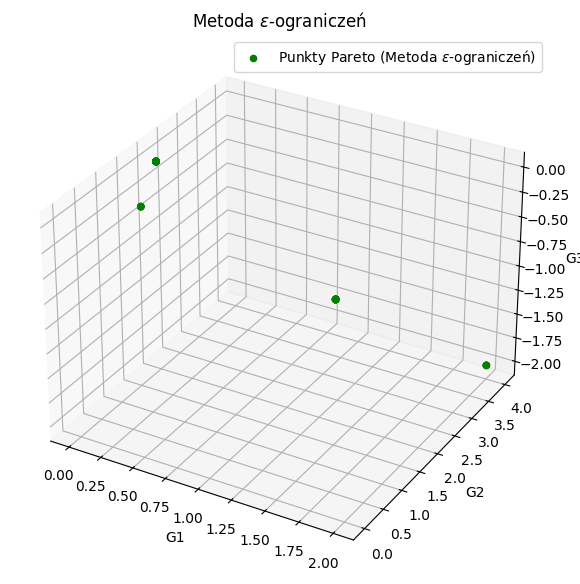

In [151]:
# Wizualizacja 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Wszystkie dostępne wartości G(u)
# ax.scatter(G_all[:, 0], G_all[:, 1], G_all[:, 2], s=5, color='gray', alpha=0.5, label='Dostępne G(u)')

# Punkty Pareto
ax.scatter(G_pareto[:, 0], G_pareto[:, 1], G_pareto[:, 2], color='green', label='Punkty Pareto (Metoda $\epsilon$-ograniczeń)')

ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')
ax.set_title('Metoda $\epsilon$-ograniczeń')
ax.legend()
plt.show()


###  Implementacja Skalaryzacji przez Odległość

In [129]:
def scalarization_distance_objective_n(u, x_dominating, lambd):
    G_values = objectives(u)
    diff = G_values - x_dominating
    weighted_diff = lambd * diff
    return np.linalg.norm(weighted_diff)

def scalarization_distance_gradient_n(u, x_dominating, lambd):
    G_values = objectives(u)
    diff = G_values - x_dominating
    weighted_diff = lambd * diff
    D_u = np.linalg.norm(weighted_diff)
    if D_u == 0:
        return np.zeros_like(u)
    grad = np.zeros_like(u)
    grad_G_values = np.array([grad_G1(u), grad_G2(u), grad_G3(u)])
    for i in range(3):
        grad += (lambd[i]**2 * (G_values[i] - x_dominating[i]) * grad_G_values[i]) / D_u
    return grad

def scalarization_distance_n(u0, x_dominating, lambd):
    def objective(u):
        return scalarization_distance_objective_n(u, x_dominating, lambd)

    def gradient(u):
        return scalarization_distance_gradient_n(u, x_dominating, lambd)

    bounds = [(-1, 1), (-1, 1), (-1, 1)]
    u_opt = gradient_descent_n(objective, gradient, u0, bounds)
    return u_opt

# Punkt dominujący
dominating_point = np.array([5.0, 5.0, 5.0])

# Generowanie kombinacji lambda
lambda_values = np.linspace(0.1, 0.9, 10)
solutions = []

for lambda1 in lambda_values:
    for lambda2 in lambda_values:
        lambda3 = 1.0 - lambda1 - lambda2
        if lambda3 >= 0 and lambda3 <= 1:
            lambd = np.array([lambda1, lambda2, lambda3])
            u_opt = scalarization_distance_n(u0=[0, 0, 0], x_dominating=dominating_point, lambd=lambd)
            G_opt = objectives(u_opt)
            solutions.append((u_opt, G_opt))

# Ekstrakcja wartości G dla punktów Pareto
G_pareto = np.array([sol[1] for sol in solutions])


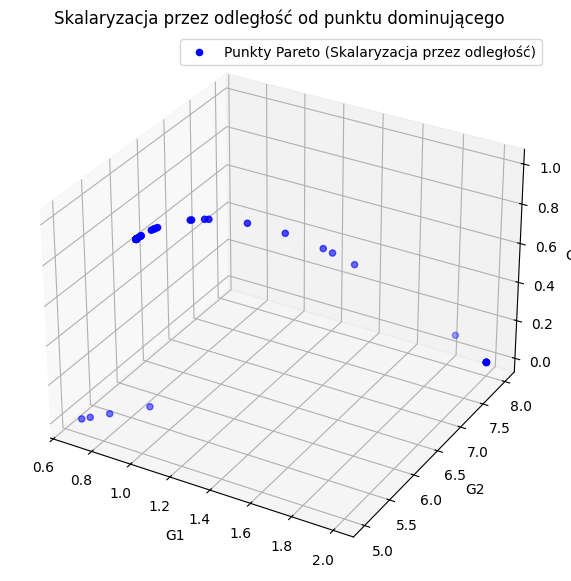

In [130]:
# Wizualizacja 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Wszystkie dostępne wartości G(u)
# ax.scatter(G_all[:, 0], G_all[:, 1], G_all[:, 2], s=5, color='gray', alpha=0.5, label='Dostępne G(u)')

# Punkty Pareto
ax.scatter(G_pareto[:, 0], G_pareto[:, 1], G_pareto[:, 2], color='blue', label='Punkty Pareto (Skalaryzacja przez odległość)')

ax.set_xlabel('G1')
ax.set_ylabel('G2')
ax.set_zlabel('G3')
ax.set_title('Skalaryzacja przez odległość od punktu dominującego')
ax.legend()
plt.show()


In [134]:
def objectives(u):
    x, y = u
    f1 = x**2 + y**2
    f2 = (x - 1)**2 + (y + 1)**2
    return np.array([f1, f2])

### Skalaryzacja przez Funkcję Liniową

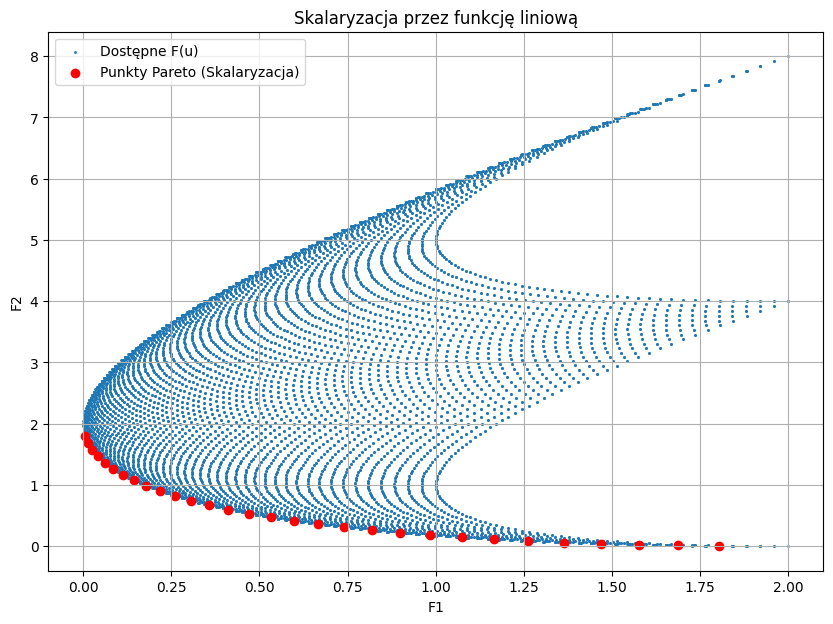

In [135]:
# Skalaryzacja przez funkcję liniową
def scalarization_linear(u0, lambd):
    def scalarized_objective(u):
        return np.dot(lambd, objectives(u))
    bounds = [(-1, 1), (-1, 1)]  # Definiuj dziedzinę U
    result = minimize(scalarized_objective, u0, bounds=bounds)
    return result

# Generuj zakres wartości lambda
lambda_values = np.linspace(0.05, 0.95, 30)
solutions = []

for lambda1 in lambda_values:
    lambd = np.array([lambda1, 1 - lambda1])
    res = scalarization_linear(u0=[0, 0], lambd=lambd)
    solutions.append((res.x, objectives(res.x)))

# Wyodrębnij wartości funkcji celu
F_values = np.array([sol[1] for sol in solutions])

# Wykres
# Generuj przestrzeń funkcji celu
x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_vals, y_vals)
U_grid = np.column_stack([X.ravel(), Y.ravel()])
F_all = np.array([objectives(u) for u in U_grid])

plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Skalaryzacja)')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Skalaryzacja przez funkcję liniową')
plt.legend()
plt.grid(True)
plt.show()

### Metoda ϵ-ograniczeń

<>:26: SyntaxWarning: invalid escape sequence '\('
<>:29: SyntaxWarning: invalid escape sequence '\('
<>:26: SyntaxWarning: invalid escape sequence '\('
<>:29: SyntaxWarning: invalid escape sequence '\('
C:\Users\Jakub\AppData\Local\Temp\ipykernel_9244\1807368399.py:26: SyntaxWarning: invalid escape sequence '\('
  plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Metoda \(\epsilon\)-ograniczeń)')
C:\Users\Jakub\AppData\Local\Temp\ipykernel_9244\1807368399.py:29: SyntaxWarning: invalid escape sequence '\('
  plt.title('Metoda \(\epsilon\)-ograniczeń')


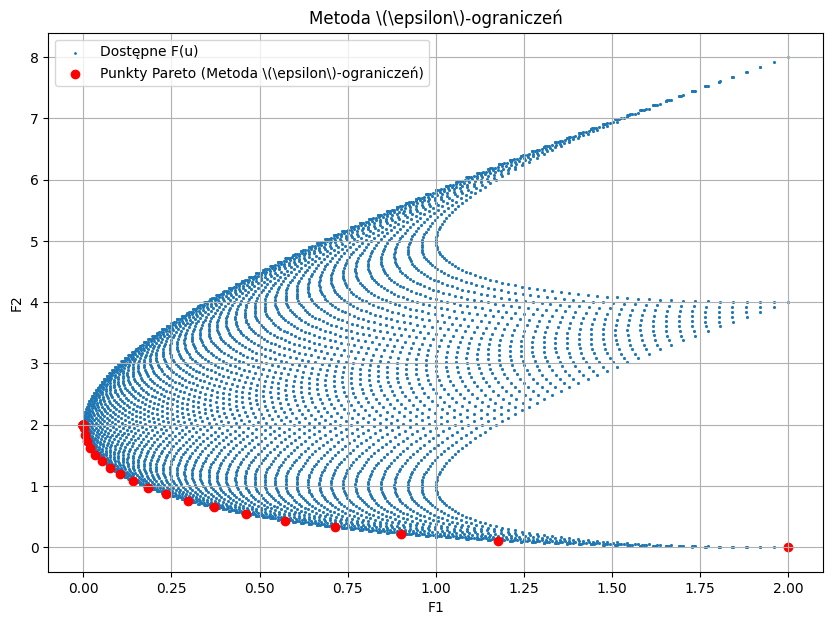

In [136]:
# Optymalizacja metodą \(\epsilon\)-ograniczeń
def epsilon_constraint_optimization(epsilon):
    def objective(u):
        return objectives(u)[0]  # Minimalizuj F1(u)
    def constraint(u):
        return epsilon - objectives(u)[1]  # F2(u) <= epsilon
    bounds = [(-1, 1), (-1, 1)]
    constraints = {'type': 'ineq', 'fun': constraint}
    result = minimize(objective, x0=[0, 0], bounds=bounds, constraints=constraints)
    return result.x, objectives(result.x)

# Generuj zakres wartości epsilon
epsilon_values = np.linspace(min(F_all[:, 1]), max(F_all[:, 1]), 75)
solutions = []

for epsilon in epsilon_values:
    res_u, res_F = epsilon_constraint_optimization(epsilon)
    solutions.append((res_u, res_F))

# Wyodrębnij wartości funkcji celu
F_values = np.array([sol[1] for sol in solutions])

# Wykres
plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Metoda \(\epsilon\)-ograniczeń)')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Metoda \(\epsilon\)-ograniczeń')
plt.legend()
plt.grid(True)
plt.show()


### Skalaryzacja przez Odległość od Wybranego Punktu Dominującego

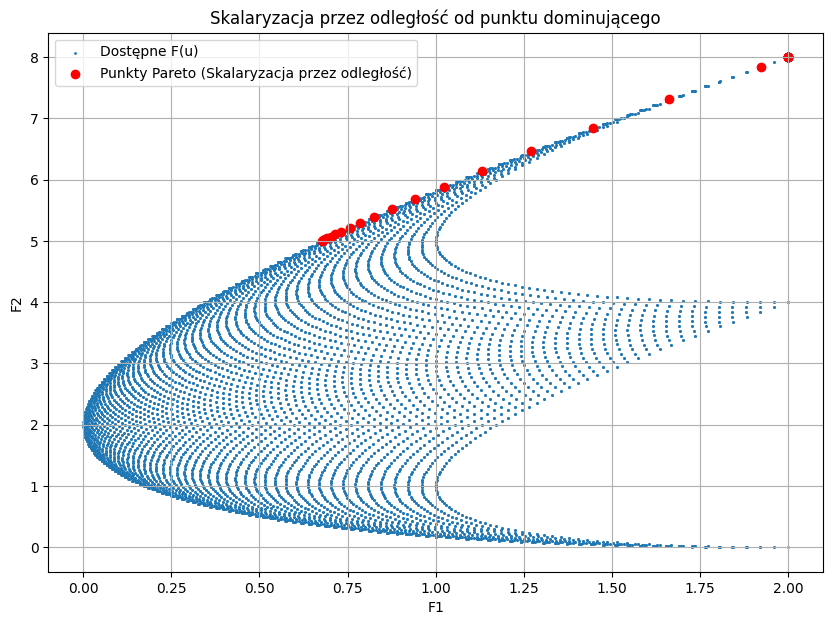

In [137]:
# Skalaryzacja przez odległość od punktu dominującego z wagami komponentowymi
def scalarization_distance(u0, x_dominating, lambd, p_norm):
    def distance_objective(u):
        diff = objectives(u) - x_dominating
        weighted_diff = lambd * np.abs(diff)
        return np.linalg.norm(weighted_diff, ord=p_norm)
    bounds = [(-1, 1), (-1, 1)]
    result = minimize(distance_objective, u0, bounds=bounds)
    return result

# Generujemy wszystkie dostępne wartości funkcji celu w dziedzinie U
x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_vals, y_vals)
U_grid = np.column_stack([X.ravel(), Y.ravel()])
F_all = np.array([objectives(u) for u in U_grid])

# Wybieramy punkt dominujący (powinien dominować wszystkie F(u))
dominating_point = np.array([5.0, 5.0])  # Upewnij się, że dominuje
p_norm = 2  # Norma euklidesowa

# Generujemy różne wektory wag lambda
lambda_values = np.linspace(0.05, 0.95, 30)  # Unikamy wartości 0 i 1
solutions = []

for lambda1 in lambda_values:
    lambda_vector = np.array([lambda1, 1 - lambda1])
    res = scalarization_distance(u0=[0, 0], x_dominating=dominating_point, lambd=lambda_vector, p_norm=p_norm)
    solutions.append((res.x, objectives(res.x), lambda_vector))

# Wyodrębniamy wartości funkcji celu dla punktów Pareto
F_values = np.array([sol[1] for sol in solutions])

# Wykres
plt.figure(figsize=(10, 7))
plt.scatter(F_all[:, 0], F_all[:, 1], s=1, label='Dostępne F(u)')
plt.scatter(F_values[:, 0], F_values[:, 1], color='red', label='Punkty Pareto (Skalaryzacja przez odległość)')
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Skalaryzacja przez odległość od punktu dominującego')
plt.legend()
plt.grid(True)
plt.show()

WYNIKI DLA CHATU:

In [138]:
# Skalaryzacja przez funkcję liniową
def scalarization_linear(u0, lambd):
    def scalarized_objective(u):
        return np.dot(lambd, objectives(u))
    bounds = [(-1, 1), (-1, 1)]  # Dziedzina U
    result = minimize(scalarized_objective, u0, bounds=bounds)
    return result

# Generuj zakres wartości lambda
lambda_values = np.linspace(0.05, 0.95, 10)
solutions_S1 = []

for lambda1 in lambda_values:
    lambd = np.array([lambda1, 1 - lambda1])
    res = scalarization_linear(u0=[0, 0], lambd=lambd)
    solutions_S1.append((res.x, objectives(res.x), lambd))

# Przygotuj dane do analizy
pareto_points_S1 = []
for sol in solutions_S1:
    u_opt, F_u_opt, lambd = sol
    pareto_points_S1.append({
        'u_opt': u_opt.tolist(),
        'F_u_opt': F_u_opt.tolist(),
        'lambda': lambd.tolist()
    })

# Wypisz dane do skopiowania
print("Punkty Pareto dla S1:")
for point in pareto_points_S1:
    print(point)

Punkty Pareto dla S1:
{'u_opt': [0.950000004367318, -0.950000004367318], 'F_u_opt': [1.8050000165958084, 0.004999999126536435], 'lambda': [0.05, 0.95]}
{'u_opt': [0.8500000054978826, -0.8500000054978826], 'F_u_opt': [1.4450000186928007, 0.044999996701270514], 'lambda': [0.15, 0.85]}
{'u_opt': [0.7500000030238105, -0.7500000030238105], 'F_u_opt': [1.1250000090714316, 0.12499999697618948], 'lambda': [0.25, 0.75]}
{'u_opt': [0.6500000069718037, -0.6500000069718037], 'F_u_opt': [0.8450000181266898, 0.2449999902394749], 'lambda': [0.35, 0.65]}
{'u_opt': [0.5500000026314067, -0.5500000026314067], 'F_u_opt': [0.6050000057890947, 0.40499999526346797], 'lambda': [0.44999999999999996, 0.55]}
{'u_opt': [0.4499999923672647, -0.45000000348060826], 'F_u_opt': [0.4049999962630857, 0.60500000456734], 'lambda': [0.5499999999999999, 0.45000000000000007]}
{'u_opt': [0.3499999931349552, -0.3500000042260723], 'F_u_opt': [0.24499999815271933, 0.8450000034306644], 'lambda': [0.65, 0.35]}
{'u_opt': [0.2499999

In [139]:
import numpy as np
from scipy.optimize import minimize

# Funkcje celu (takie same jak wcześniej)
def objectives(u):
    x, y = u
    f1 = x**2 + y**2
    f2 = (x - 1)**2 + (y + 1)**2
    return np.array([f1, f2])

# Optymalizacja metodą \(\epsilon\)-ograniczeń
def epsilon_constraint_optimization(epsilon):
    def objective(u):
        return objectives(u)[0]  # Minimalizuj F1(u)
    def constraint(u):
        return epsilon - objectives(u)[1]  # F2(u) <= epsilon
    bounds = [(-1, 1), (-1, 1)]
    constraints = {'type': 'ineq', 'fun': constraint}
    result = minimize(objective, x0=[0, 0], bounds=bounds, constraints=constraints)
    return result

# Generuj zakres wartości epsilon
epsilon_values = np.linspace(0.5, 5, 10)
solutions_S2 = []

for epsilon in epsilon_values:
    res = epsilon_constraint_optimization(epsilon)
    solutions_S2.append((res.x, objectives(res.x), epsilon))

# Przygotuj dane do analizy
pareto_points_S2 = []
for sol in solutions_S2:
    u_opt, F_u_opt, epsilon = sol
    pareto_points_S2.append({
        'u_opt': u_opt.tolist(),
        'F_u_opt': F_u_opt.tolist(),
        'epsilon': epsilon
    })

# Wypisz dane do skopiowania
print("Punkty Pareto dla S2:")
for point in pareto_points_S2:
    print(point)

Punkty Pareto dla S2:
{'u_opt': [0.4999996769872176, -0.500000322377287], 'F_u_opt': [0.49999999936471284, 0.5000000006357037], 'epsilon': np.float64(0.5)}
{'u_opt': [0.29289322517104216, -0.29289313234322756], 'F_u_opt': [0.1715728283249222, 1.000000113296383], 'epsilon': np.float64(1.0)}
{'u_opt': [0.13397460200307734, -0.1339745903970918], 'F_u_opt': [0.0358983848539515, 1.5000000000536131], 'epsilon': np.float64(1.5)}
{'u_opt': [0.0, 0.0], 'F_u_opt': [0.0, 2.0], 'epsilon': np.float64(2.0)}
{'u_opt': [0.0, 0.0], 'F_u_opt': [0.0, 2.0], 'epsilon': np.float64(2.5)}
{'u_opt': [0.0, 0.0], 'F_u_opt': [0.0, 2.0], 'epsilon': np.float64(3.0)}
{'u_opt': [0.0, 0.0], 'F_u_opt': [0.0, 2.0], 'epsilon': np.float64(3.5)}
{'u_opt': [0.0, 0.0], 'F_u_opt': [0.0, 2.0], 'epsilon': np.float64(4.0)}
{'u_opt': [0.0, 0.0], 'F_u_opt': [0.0, 2.0], 'epsilon': np.float64(4.5)}
{'u_opt': [0.0, 0.0], 'F_u_opt': [0.0, 2.0], 'epsilon': np.float64(5.0)}


In [140]:
import numpy as np
from scipy.optimize import minimize

# Funkcje celu (takie same jak wcześniej)
def objectives(u):
    x, y = u
    f1 = x**2 + y**2
    f2 = (x - 1)**2 + (y + 1)**2
    return np.array([f1, f2])

# Poprawiona funkcja skalaryzacji przez odległość od punktu dominującego
def scalarization_distance(u0, x_dominating, lambd, p_norm):
    def distance_objective(u):
        diff = objectives(u) - x_dominating
        weighted_diff = lambd * np.abs(diff)
        return np.linalg.norm(weighted_diff, ord=p_norm)
    bounds = [(-1, 1), (-1, 1)]
    result = minimize(distance_objective, u0, bounds=bounds)
    return result

# Wybierz punkt dominujący, który dominuje wszystkie możliwe F(u)
dominating_point = np.array([5.0, 5.0])  # Upewnij się, że dominuje
p_norm = 2  # Norma euklidesowa
solutions_S3 = []

# Generuj różne wektory lambda
lambda_values = np.linspace(0.1, 1.0, 10)
for lambda1 in lambda_values:
    lambd = np.array([lambda1, 1 - lambda1])
    res = scalarization_distance(u0=[0, 0], x_dominating=dominating_point, lambd=lambd, p_norm=p_norm)
    solutions_S3.append((res.x, objectives(res.x), lambd))

# Przygotuj dane do analizy
pareto_points_S3 = []
for sol in solutions_S3:
    u_opt, F_u_opt, lambd = sol
    pareto_points_S3.append({
        'u_opt': u_opt.tolist(),
        'F_u_opt': F_u_opt.tolist(),
        'lambda': lambd.tolist()
    })

# Wypisz dane do skopiowania
print("Punkty Pareto dla S3:")
for point in pareto_points_S3:
    print(point)


Punkty Pareto dla S3:
{'u_opt': [-0.5842437163029802, 0.5842437057538699], 'F_u_opt': [0.6826814277525317, 5.019656271866232], 'lambda': [0.1, 0.9]}
{'u_opt': [-0.5968969628721184, 0.5968969495002614], 'F_u_opt': [0.7125719526086767, 5.100159777353436], 'lambda': [0.2, 0.8]}
{'u_opt': [-0.627625771897994, 0.6276257603088232], 'F_u_opt': [0.7878282045537812, 5.298331268967416], 'lambda': [0.30000000000000004, 0.7]}
{'u_opt': [-0.6933597229674797, 0.693359585976206], 'F_u_opt': [0.961495220898636, 5.734933838786007], 'lambda': [0.4, 0.6]}
{'u_opt': [-0.8228756571784449, 0.8228756487111657], 'F_u_opt': [1.3542486804186793, 6.6457512921979], 'lambda': [0.5, 0.5]}
{'u_opt': [-1.0, 1.0], 'F_u_opt': [2.0, 8.0], 'lambda': [0.6, 0.4]}
{'u_opt': [-1.0, 0.9999997351889205], 'F_u_opt': [1.9999994703779111, 7.999998940755752], 'lambda': [0.7000000000000001, 0.29999999999999993]}
{'u_opt': [-1.0, 0.9999994502102809], 'F_u_opt': [1.9999989004208643, 7.999997800841426], 'lambda': [0.8, 0.1999999999999